# Prerequisites installation

In [ ]:
!pip install prophet

In [ ]:
!pip install plotly statsmodels

In [ ]:
!pip install pylab-sdk

# Imports

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt

### Loading the dataset.

In [ ]:
df = pd.read_csv('/content/hotel_bookings.csv').rename(columns={'arrival_date_year':'year','arrival_date_month':'month',
                     'arrival_date_day_of_month':'day'})

In [ ]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'year', 'month',
       'arrival_date_week_number', 'day', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [ ]:
df.tail(1)

,hotel,is_canceled,lead_time,year,month,arrival_date_week_number,day,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
119389,City Hotel,0,205,2024,August,35,29,2,7,2,...,No Deposit,9.0,NaN,0,Transient,151.2,0,2,Check-Out,07-09-2024


### Coverting the months to their numeric values

In [ ]:
# Define a function to convert month names to their corresponding numerical values
def monthToNum(shortMonth):
    return {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9,
            'October': 10,
            'November': 11,
            'December': 12
    }[shortMonth]

# Apply the monthToNum function to the 'month' column to convert month names to numbers
df['month'] = df['month'].apply(monthToNum)

# Create a new 'date' column by combining 'year', 'month', and 'day' columns, handling errors by coercing invalid dates to NaT
df['date']= pd.to_datetime(df[["year", "month", "day"]],  errors='coerce')

# Filter the DataFrame to include only rows where the booking was not canceled and the hotel is 'Resort Hotel'
df = df[(df['is_canceled']==0) & (df['hotel']=='Resort Hotel')]

# Group the filtered DataFrame by 'date' and count the number of bookings for each date
# Reset the index and rename the columns to 'ds' (date) and 'y' (number of bookings) for compatibility with time series models
t_df = df.groupby(['date'])['hotel'].count().reset_index().rename(columns={'hotel':'y','date':'ds'})


In [ ]:
t_df.head()

,ds,y
0,2022-07-01,38
1,2022-07-02,35
2,2022-07-03,27
3,2022-07-04,36
4,2022-07-05,37


In [ ]:
t_df.to_csv('ts_latest_data.csv')

### Visualizing hotel demand over time

In [ ]:
fig = px.line(t_df, x="ds", y="y", title='hotel demands')
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


### Splitting the data into train and test.

- 'train_df' includes data from July 1, 2022, to August 31, 2024
- 'test_df' includes data from September 1, 2024, to September 30, 2024


In [ ]:
train_df = t_df.loc[(t_df['ds']>='2022-07-01') & (t_df['ds']<'2024-09-01')]
test_df = t_df.loc[(t_df['ds']>='2024-09-01') & (t_df['ds']<'2024-10-01')]

# Prophet

In [ ]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt

In [ ]:
train_df_prophet = t_df.copy()
model = Prophet(weekly_seasonality=True)
model.fit(train_df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7myph_ri/qg2fjhpk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7myph_ri/wdxo7wjj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5333', 'data', 'file=/tmp/tmp7myph_ri/qg2fjhpk.json', 'init=/tmp/tmp7myph_ri/wdxo7wjj.json', 'output', 'file=/tmp/tmp7myph_ri/prophet_modelwn89tb78/prophet_model-20241001065835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:58:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:58:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast = model.make_future_dataframe(periods=31)
pred = model.predict(forecast)

In [ ]:
#delete
len(t_df)

792

In [ ]:
pred['yhat'][-31:-1]

,yhat
792,36.745998
793,36.334419
794,38.616681
795,36.307204
796,32.564149
797,37.600493
798,37.289261
799,37.182985
800,36.653318
801,38.809679


In [ ]:
len(pred['yhat'][-31:-1])

30

### Calculating the average of the last 30 values (Month)

In [ ]:
sum(pred['yhat'][-31:])/len(pred['yhat'][-31:])

36.87273958627094

In [ ]:
sum(t_df['y'])/len(t_df['y'])

36.50757575757576

### Forecast plot- Prophet model

- 'pred' is the DataFrame containing the forecasted values



/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



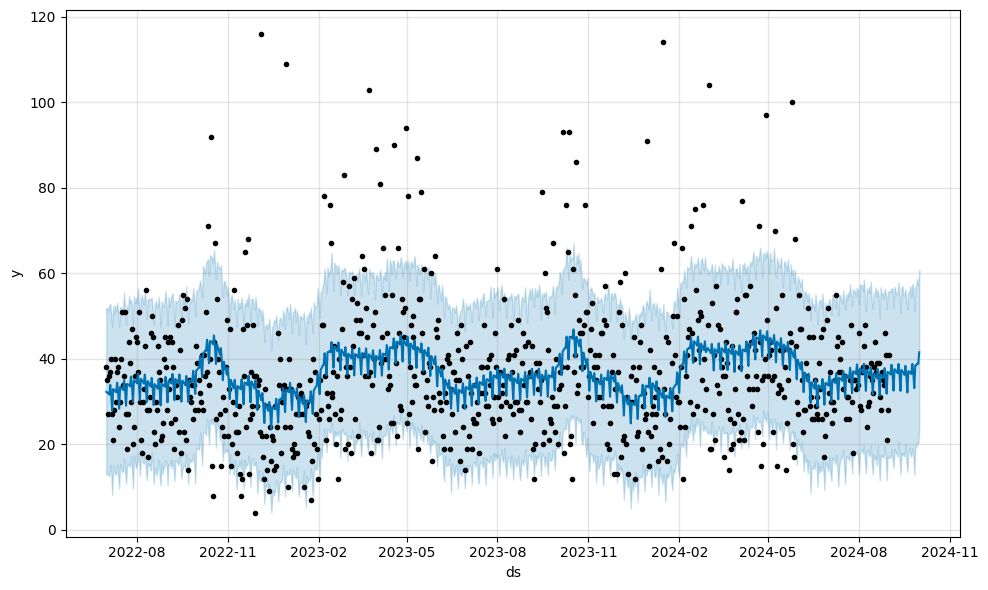

In [ ]:
prophet_plot = model.plot(pred)


### Plotting individual components of the forecast (trend, weekly seasonality, yearly seasonality)

- trend:  represents the long-term movement in the data. It shows the overall direction in which the data is moving over time, whether it’s increasing, decreasing, or remaining stable.

- Weekly seasonality: captures the recurring patterns that occur within a week

- Yearly seasonality captures the recurring patterns that occur within a year. This could include variations due to holidays, seasons, or other annual events.



/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



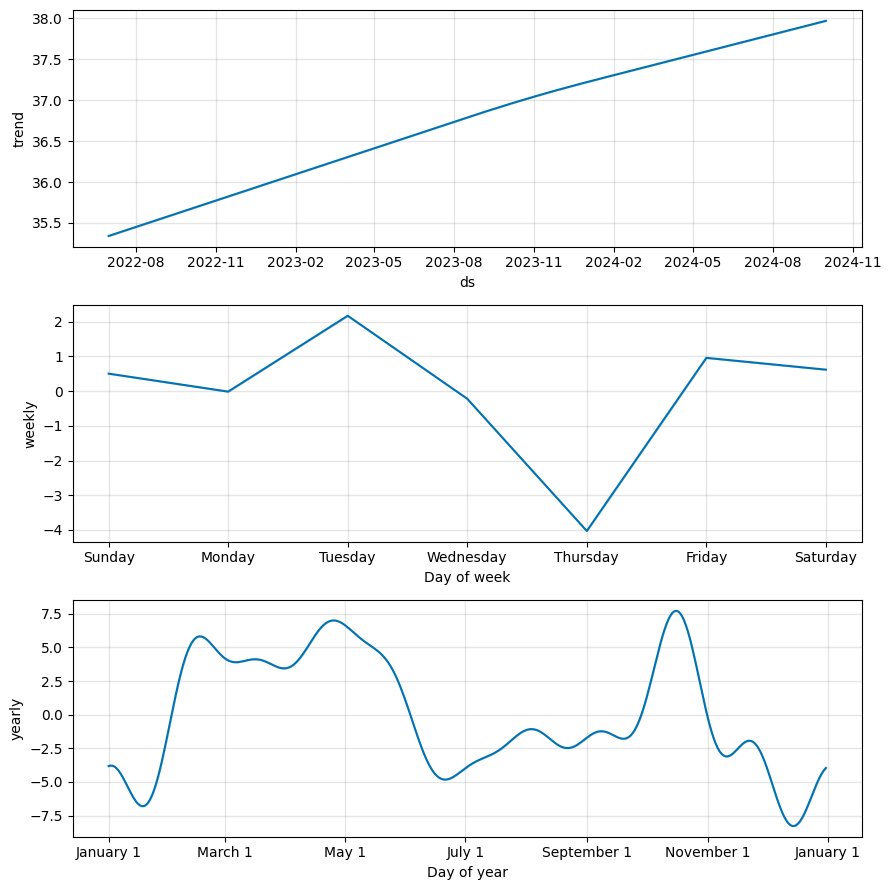

In [ ]:
prophet_plot2 = model.plot_components(pred)

**Interpretation of Graph**
1. **Top Graph - Trends** : The line shows an upward trend over time, indicating that the ‘temp’ variable is increasing steadily from 2022 to 2024. This could represent a long-term increase in temperature or another metric over the given period.

2. **Middle Graph - Weekly Seasonality:** The line has peaks and troughs corresponding to different days of the week, showing a recurring pattern. This suggests that ‘velocity’ varies regularly within a week, with certain days having higher or lower values.

3. **Bottom Graph (Yearly Seasonality):** The wavy line fluctuates above and below zero, indicating a cyclical pattern that repeats annually. This suggests that ‘displacement’ experiences regular seasonal changes throughout the year.

# Dumping model

In [ ]:
import joblib

In [ ]:
joblib.dump(model, "prophet_model.joblib")

['prophet_model.joblib']

In [ ]:
model = joblib.load("prophet_model.joblib")

In [ ]:
forecast = model.make_future_dataframe(periods=31)
pred = model.predict(forecast)

# Storing joblib file to bucket

In [ ]:
from google.cloud import storage

Bucket Name

In [ ]:
# @title
bucket_name = "devfolio"

In [ ]:
file_name = "/content/prophet_model.joblib"
blob_name = "prophet_model.joblib"

In [ ]:
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(blob_name)

In [ ]:
blob.upload_from_filename(file_name)